# A study on spontaneous decay rate of an atom in presence of a square dielectric waveguide using BEM approach

In these notes, I calculate the Local Density of States (LDOS), or the imaginary part of the on-site Green's function and hence the modified spontaneous emission rate of an atom in presence of a square dielectric waveguide using the Boundary Element Method (BEM). The BEM code is from Prof. Alejandro Manjavacas's group. 

This is an [IJulia notebook](https://github.com/JuliaLang/IJulia.jl), which provides a nice
browser-based [Jupyter](http://jupyter.org/) interface to the [Julia language](http://julialang.org/), a high-level dynamic language (similar to Matlab or Python+SciPy) for technical computing.  The notebook allows us to combine code and results in one place.

We are only manipulating the generated data from the simulation results in this notebook. As a brief recap of the simulation process, I have used a compiled BEM code by Alejandro's group written in C++ called `bem2D` on a cluster computing system. A configuration C++ code is defined in the file `scripts_ldos.cpp` which is in the same folder as `bem2D`. I compiled the script and put the generated executable into another folder called `p3`, for example, by
```
g++ scripts_ldos.cpp -lstdc++ -o ../p3/scripts_ldos
```
Then ran the executable and submitted the generated PBS script to the cluster system to run the simulation:
```
cd ../p3/
./scripts_ldos
qsub ldos_N_1_lam_894_eps_4_0_a_300_b_300_c_5_x_0_y_350_q_0_2_401.pbs
```
Notice that the name of the PBS script is automatically generated based on the configuration parameters for this simulation. The name will vary for different simulations. After running the script, I got a set of data files--one has the same name as the PBS script but with a `.dat` extension for the data table storing the calculated LDOS values; there are another two `*.dat` files for the geometry of boundary and dieletric function distribution. We will look into those data files in the following sections.


## 3D dielectric waveguide simulated in 2D

Just a little more detail on the simulation itself: By assuming the waveguide along z-axis or the light propagation direction is uniform, one can completely solve the boundary condition problem of dipole emission by simulating the field in one single layer of the xy cross section. The z-component of the field only adds in a phase factor. The data of the simulated result is stored in the /data/ folder of this repo. 

We can read in this data as a matrix of numbers by the `readdlm` function in Julia with the `header=false` option meaning that it reads the first line as the beginning of the data entries without a list of strings describing each column.

Now, let's plot the results.  I'll use the [PyPlot](https://github.com/stevengj/PyPlot.jl) package in Julia, which is an interface to the sophisticated [matplotlib](http://matplotlib.org/) Python plotting library.   We'll plot three things:

* The waveguide structure in terms of $\epsilon$ and the interface boundary between two media.
* Plot the LDOS components for a fixed dipole position.
* Calculate the waveguide-modified spontaneous decay rate when the dipole varies its position outside of the waveguide.



### Plotting the boundary and index of refraction profile of the waveguide in the xy cross section

Our boundary points are meshed in the file `/data/p3/geom_regions_a_300_b_300_c_5.data`, which positions where the equivalent charges and current sources to be computed in the BEM simulation. The waveguide has a square cross-section of a width $a=b=300nm$ ($nm$ is the unit of length) and a index of refraction of $n_1=n_{core}=2$ for the waveguide material and $n_2=n_{clad}=1$ for the vacuum clad. 

It is good to plot out the mesh of index of refraction in space and find out how good is the mesh resolution. This can be done by plotting out the output eps file in a simple data table format, which ends in `.dat`. 

The following will first print out some of the data in order to figure out the physics meaning of the dimensions. They should contain the coordinate and index of refraction information for the simulation.

Another set of data is taken at $r=330nm$ position with a slightly different setting--mainly the edges are having a larger radius. We can plot the result below.

As plotted below, the dipole is changing position from $225$nm to $420$nm from the origin (center of the waveguide) along the x-axis. 

The guide mode contribution seems very small compared to the nanofiber case using the BEM approach. As discussed in other tests, the BEM calculation on the guided mode contribution part is not accurate due to the fact that the dielectric function has a zero imaginary part or loss in the frequency domain which will cause an infinite narrow peak of the LDOS function and leads to unphysical solution. 
To avoid this difficulty, we will use other method to calculate the guided mode contribution part to the Green's function tensor.

# Calculation of Green's function tensor using BEM

BEM can output full local field components so that computing the radiative mode contribution to the full Green's function tensor is possible. With the Green's function tensor, one can then calculate the modified decay rates with dipoles orientated along arbitrary directions--including the dipole transitions corresponding to $\sigma_\pm$ and $\pi$ transitions.

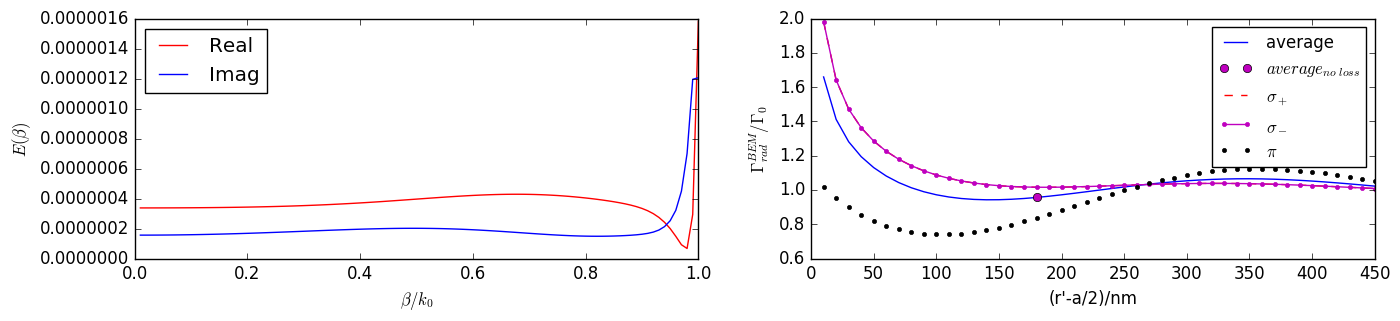

In [1]:
# Load data for different dipole positions.
rp_BEM=160:10:600;#[170,190,210,230,250,270,290,310,330,350,370,390,410,430,450,470];
lenrp=length(rp_BEM);
lendr=201;
E_dipolex = readdlm("data/D2/dipolex_E_N_1_lam_852_eps_4_0.001_a_300_b_300_c_6_x_330_y_0_q_0_2_201.dat", header=false);
k_vec=E_dipolex[:,2];
Ex_dx=zeros(Complex{Float64},lendr,lenrp); Ey_dx=zeros(Complex{Float64},lendr,lenrp); Ez_dx=zeros(Complex{Float64},lendr,lenrp);
Ex_dy=zeros(Complex{Float64},lendr,lenrp); Ey_dy=zeros(Complex{Float64},lendr,lenrp); Ez_dy=zeros(Complex{Float64},lendr,lenrp);
Ex_dz=zeros(Complex{Float64},lendr,lenrp); Ey_dz=zeros(Complex{Float64},lendr,lenrp); Ez_dz=zeros(Complex{Float64},lendr,lenrp);
for ii=2:2:(lenrp-1)
    E_dipolex = readdlm("data/D2/dipolex_E_N_1_lam_852_eps_4_0.001_a_300_b_300_c_6_x_$(rp_BEM[ii])_y_0_q_0_2_201.dat", header=false); #",rp_list[ii],"
    Ex_dx[:,ii]=E_dipolex[:,5]+im*E_dipolex[:,6];
    Ey_dx[:,ii]=E_dipolex[:,7]+im*E_dipolex[:,8];
    Ez_dx[:,ii]=E_dipolex[:,9]+im*E_dipolex[:,10];
    
    E_dipoley = readdlm("data/D2/dipoley_E_N_1_lam_852_eps_4_0.001_a_300_b_300_c_6_x_$(rp_BEM[ii])_y_0_q_0_2_201.dat", header=false); #",rp_list[ii],"
    Ex_dy[:,ii]=E_dipoley[:,5]+im*E_dipoley[:,6];
    Ey_dy[:,ii]=E_dipoley[:,7]+im*E_dipoley[:,8];
    Ez_dy[:,ii]=E_dipoley[:,9]+im*E_dipoley[:,10];
    
    E_dipolez = readdlm("data/D2/dipolez_E_N_1_lam_852_eps_4_0.001_a_300_b_300_c_6_x_$(rp_BEM[ii])_y_0_q_0_2_201.dat", header=false); #",rp_list[ii],"
    Ex_dz[:,ii]=E_dipolez[:,5]+im*E_dipolez[:,6];
    Ey_dz[:,ii]=E_dipolez[:,7]+im*E_dipolez[:,8];
    Ez_dz[:,ii]=E_dipolez[:,9]+im*E_dipolez[:,10];
end
for ii=1:2:lenrp
    E_dipolex = readdlm("data/D2/dipolex_E_N_1_lam_852_eps_4_0.001_a_300_b_300_c_6_x_$(rp_BEM[ii])_y_0_q_0_2_201.dat", header=false); #",rp_list[ii],"
    Ex_dx[:,ii]=E_dipolex[:,5]+im*E_dipolex[:,6];
    Ey_dx[:,ii]=E_dipolex[:,7]+im*E_dipolex[:,8];
    Ez_dx[:,ii]=E_dipolex[:,9]+im*E_dipolex[:,10];
    
    E_dipoley = readdlm("data/D2/dipoley_E_N_1_lam_852_eps_4_0.001_a_300_b_300_c_6_x_$(rp_BEM[ii])_y_0_q_0_2_201.dat", header=false); #",rp_list[ii],"
    Ex_dy[:,ii]=E_dipoley[:,5]+im*E_dipoley[:,6];
    Ey_dy[:,ii]=E_dipoley[:,7]+im*E_dipoley[:,8];
    Ez_dy[:,ii]=E_dipoley[:,9]+im*E_dipoley[:,10];
    
    E_dipolez = readdlm("data/D2/dipolez_E_N_1_lam_852_eps_4_0.001_a_300_b_300_c_6_x_$(rp_BEM[ii])_y_0_q_0_2_201.dat", header=false); #",rp_list[ii],"
    Ex_dz[:,ii]=E_dipolez[:,5]+im*E_dipolez[:,6];
    Ey_dz[:,ii]=E_dipolez[:,7]+im*E_dipolez[:,8];
    Ez_dz[:,ii]=E_dipolez[:,9]+im*E_dipolez[:,10];
end
# Calculate the diagonal elements of the Green's function tensor from the radiation mode contribution.
c=2.99792458e8;
au=1.72e7; # This is the atomic unit in the CGS-units: $q/a_0^2$ statvolts/cm. In SI units, it becomes $e/(4π\varepsilon_0a_0^2)$ = 5.2e11 V/m.
lambda0=0.895e-6;
ω=2.*pi*c/lambda0;
GFT_rad_ind=zeros(Complex{Float64},3,3,lenrp);
Gxx_rad_ind=zeros(Complex{Float64},lenrp);
Gxy_rad_ind=zeros(Complex{Float64},lenrp);
Gxz_rad_ind=zeros(Complex{Float64},lenrp);
Gyx_rad_ind=zeros(Complex{Float64},lenrp);
Gyy_rad_ind=zeros(Complex{Float64},lenrp);
Gyz_rad_ind=zeros(Complex{Float64},lenrp);
Gzx_rad_ind=zeros(Complex{Float64},lenrp);
Gzy_rad_ind=zeros(Complex{Float64},lenrp);
Gzz_rad_ind=zeros(Complex{Float64},lenrp);
G0=Inf + 2.0/3.*(ω/c)^3*im;
gamma_rad_BEM_rp_average=zeros(lenrp);
gamma_rad_BEM_rp_sigmap=zeros(lenrp);
gamma_rad_BEM_rp_sigmam=zeros(lenrp);
gamma_rad_BEM_rp_pi=zeros(lenrp);
# Define the unitary dipole orientation vector.
e_dipole_sigmap=[-1.;-1.0*im;0]/sqrt(2);
e_dipole_sigmam=[1.; -1.0*im;0]/sqrt(2);
e_dipole_pi=[0.; 0.; 1.];
breakpoint=100; # The index of k vector to cut off for the radiative mode in the range of [0,1]k_0.
using NumericalIntegration
for ii=1:lenrp
    Gxx_rad_ind[ii]=integrate(k_vec[1:breakpoint],Ex_dx[1:breakpoint,ii],Trapezoidal())*(ω/c)^3/pi^2*au*4.0/3.;#G0+
    Gyy_rad_ind[ii]=integrate(k_vec[1:breakpoint],Ey_dy[1:breakpoint,ii],Trapezoidal())*(ω/c)^3/pi^2*au*4.0/3.;#G0+
    Gzz_rad_ind[ii]=integrate(k_vec[1:breakpoint],Ez_dz[1:breakpoint,ii],Trapezoidal())*(ω/c)^3/pi^2*au*4.0/3.;#G0+
    Gyx_rad_ind[ii]=integrate(k_vec[1:breakpoint],Ey_dx[1:breakpoint,ii],Trapezoidal())*(ω/c)^3/pi^2*au*4.0/3.;
    Gzx_rad_ind[ii]=integrate(k_vec[1:breakpoint],Ez_dx[1:breakpoint,ii],Trapezoidal())*(ω/c)^3/pi^2*au*4.0/3.;
    Gxy_rad_ind[ii]=integrate(k_vec[1:breakpoint],Ex_dy[1:breakpoint,ii],Trapezoidal())*(ω/c)^3/pi^2*au*4.0/3.;
    Gzy_rad_ind[ii]=integrate(k_vec[1:breakpoint],Ez_dy[1:breakpoint,ii],Trapezoidal())*(ω/c)^3/pi^2*au*4.0/3.;
    Gxz_rad_ind[ii]=integrate(k_vec[1:breakpoint],Ex_dz[1:breakpoint,ii],Trapezoidal())*(ω/c)^3/pi^2*au*4.0/3.;
    Gyz_rad_ind[ii]=integrate(k_vec[1:breakpoint],Ey_dz[1:breakpoint,ii],Trapezoidal())*(ω/c)^3/pi^2*au*4.0/3.;
    GFT_rad_ind[:,:,ii]=[Gxx_rad_ind[ii] Gxy_rad_ind[ii] Gxz_rad_ind[ii];
        Gyx_rad_ind[ii] Gyy_rad_ind[ii] Gzy_rad_ind[ii];
        Gzx_rad_ind[ii] Gzy_rad_ind[ii] Gzz_rad_ind[ii]];
end

# Calculate the relative averaged decay rate at the given dipole located at x=405nm and y=0.
gamma0=imag(G0);
for ii =1:lenrp
    gamma_rad_BEM_rp_average[ii]=1+trace(imag(GFT_rad_ind[:,:,ii]))/gamma0/3.;
    gamma_rad_BEM_rp_sigmap[ii]=1+real((e_dipole_sigmap'*imag(GFT_rad_ind[:,:,ii])*e_dipole_sigmap)/gamma0)[1];
    gamma_rad_BEM_rp_sigmam[ii]=1+real((e_dipole_sigmam'*imag(GFT_rad_ind[:,:,ii])*e_dipole_sigmam)/gamma0)[1];
    gamma_rad_BEM_rp_pi[ii]=1+real((e_dipole_pi'*imag(GFT_rad_ind[:,:,ii])*e_dipole_pi)/gamma0)[1];
end

# Recalculate the diagonal GFT elements with a dipole placed at r'=405nm from the fiber axis with lower imaginary part of epsilon.
E_dipolex = readdlm(join(["data/D2/dipolex_E_N_1_lam_852_eps_4_0.001_a_300_b_300_c_6_x_","330","_y_0_q_0_2_201.dat"]), header=false)
Ex_dx_r0=E_dipolex[:,5]+im*E_dipolex[:,6];
Ey_dx_r0=E_dipolex[:,7]+im*E_dipolex[:,8];
Ez_dx_r0=E_dipolex[:,9]+im*E_dipolex[:,10];
E_dipoley = readdlm(join(["data/D2/dipoley_E_N_1_lam_852_eps_4_0.001_a_300_b_300_c_6_x_","330","_y_0_q_0_2_201.dat"]), header=false)
Ex_dy_r0=E_dipoley[:,5]+im*E_dipoley[:,6];
Ey_dy_r0=E_dipoley[:,7]+im*E_dipoley[:,8];
Ez_dy_r0=E_dipoley[:,9]+im*E_dipoley[:,10];
E_dipolez = readdlm(join(["data/D2/dipolez_E_N_1_lam_852_eps_4_0.001_a_300_b_300_c_6_x_","330","_y_0_q_0_2_201.dat"]), header=false)
Ex_dz_r0=E_dipolez[:,5]+im*E_dipolez[:,6];
Ey_dz_r0=E_dipolez[:,7]+im*E_dipolez[:,8];
Ez_dz_r0=E_dipolez[:,9]+im*E_dipolez[:,10];
Gxx_rad_r0=integrate(k_vec[1:breakpoint],Ex_dx_r0[1:breakpoint],Trapezoidal())*(ω/c)^3/pi^2*au*4.0/3.;
Gyy_rad_r0=integrate(k_vec[1:breakpoint],Ey_dy_r0[1:breakpoint],Trapezoidal())*(ω/c)^3/pi^2*au*4.0/3.;
Gzz_rad_r0=integrate(k_vec[1:breakpoint],Ez_dz_r0[1:breakpoint],Trapezoidal())*(ω/c)^3/pi^2*au*4.0/3.;
gamma_rad_BEM_r0=imag(Gxx_rad_r0+Gyy_rad_r0+Gzz_rad_r0)/3/gamma0;

# Plot out gamma_rad as a function of dipole position.
using PyPlot
figure(figsize=(16,3));
subplot(1,2,1)
plot((1:breakpoint)/100.,real(Ex_dx[1:breakpoint,4]),"r-")
plot((1:breakpoint)/100.,imag(Ex_dx[1:breakpoint,4]),"b-")
ylabel(L"E(\beta)")
xlabel(L"\beta/k_0")
legend(["Real","Imag"],loc="upper left")

subplot(1,2,2)
a=300.;
#plot(rp0_test[1,:]/1.e-9, 1+sum(gamma_rad,2), "r-", linewidth=2.0)
plot(rp_BEM-a/2,real(gamma_rad_BEM_rp_average),"b-");
plot(330-a/2,real(gamma_rad_BEM_r0)+1.,"mo");
plot(rp_BEM-a/2,gamma_rad_BEM_rp_sigmap,"r--");
plot(rp_BEM-a/2,gamma_rad_BEM_rp_sigmam,"m.-");
plot(rp_BEM-a/2,gamma_rad_BEM_rp_pi,"k.");
xlabel("(r'-a/2)/nm");
ylabel(L"\Gamma_{rad}^{BEM}/\Gamma_0");
#ylim([0,1.2])
legend(["average",L"average_{no\,\,loss}",L"\sigma_+",L"\sigma_-",L"\pi"],loc="upper right",fontsize=12);
#gamma_rad_BEM_rp_sigmap

The first figure (on the left) shows the real and imaginary parts of the $E_x$ component changes as a function of $\beta=k_z$ in the radiative mode regime.

The second figure (on the right) shows the decay rates caused by non-guided modes and decomposed into the $\sigma_\pm$ and $\pi$ transitions and their average.
In calculating the averaged non-guided mode induced decay rates, we define
$$\begin{align}
\frac{\Gamma_{rad}^{ave}}{\Gamma_0} &= 1+ \frac{\sum_{i=x,y,z}\mathrm{Im}\left[\mathbf{e}_i^*\cdot \mathbf{G}_{ind,rad}(\mathbf{r}',\mathbf{r}')\cdot \mathbf{e}_i\right]}{\sum_{i=x,y,z} \mathrm{Im}\left[\mathbf{e}_i^*\cdot \mathbf{G}_0(\mathbf{r}',\mathbf{r}')\cdot \mathbf{e}_i\right]}\\
&=1+ \frac{\sum_{i=x,y,z}\mathrm{Im}\left[\mathbf{e}_i^*\cdot \mathbf{G}_{ind,rad}(\mathbf{r}',\mathbf{r}')\cdot \mathbf{e}_i\right]}{3\mathrm{Im}\left[G_0(\mathbf{r}',\mathbf{r}')\right]}\\
&= 1+ \frac{\mathrm{Tr}\left\{\mathrm{Im}\left[ \mathbf{G}_{ind,rad}(\mathbf{r}',\mathbf{r}')\right]\right\}}{3\mathrm{Im}\left[G_0(\mathbf{r}',\mathbf{r}')\right]}
\end{align}$$
with the free-space Green's function scaled by $G_0(\mathbf{r}',\mathbf{r}';\omega)=\frac{2}{3}k_0^3$ in the CGS units as $\mathbf{G}_0=G_0\mathbb{1}$ and the numerical result of the waveguide-induced Green's function tensor elements
$$ G_{ind,rad}^{ij}(\mathbf{r}',\mathbf{r}')=\frac{2k_0^2*a.u.}{3\pi^2}\int_{-k_0}^{k_0} d\beta E_j^i(\mathbf{r}')=\frac{4k_0^2*a.u.}{3\pi^2}\int_{0}^{k_0} d\beta E_j^i(\mathbf{r}')$$
calculated via BEM by putting a unit dipole in atomic units orientated along $j$ direction while the $i$-th electric field component is measured at the dipole position.
We have used $\varepsilon=4+0.01i$ (with a small loss) and $\varepsilon=4$ (without loss) to calculate the Green's function tensors as well as the averaged corresponding decay rate contributions.
These two cases doesn't show a noticeable difference with one sampling data point as shown in the purple dot points. 

In calculating the corresponding contributions from the $\sigma_\pm$ and $\pi$ transitions of the atoms, we have defined
$$\begin{align}
\frac{\Gamma_{rad}^{\mathbf{e}_q}}{\Gamma_0} &= 1+ \frac{\mathrm{Im}\left[\mathbf{e}_q^*\cdot \mathbf{G}_{ind,rad}(\mathbf{r}',\mathbf{r}')\cdot \mathbf{e}_q\right]}{ \mathrm{Im}\left[\mathbf{e}_q^*\cdot \mathbf{G}_0(\mathbf{r}',\mathbf{r}')\cdot \mathbf{e}_q\right]}
=1+ \frac{\mathrm{Im}\left[\mathbf{e}_q^*\cdot \mathbf{G}_{ind,rad}(\mathbf{r}',\mathbf{r}')\cdot \mathbf{e}_q\right]}{\mathrm{Im}\left[G_0(\mathbf{r}',\mathbf{r}')\right]},
\end{align}$$
where the three orthogonal dipole transition bases
$$\begin{align}
\mathbf{e}_\pm &=\mp \frac{\mathbf{e}_{\tilde{x}}\pm i\mathbf{e}_{\tilde{y}}}{\sqrt{2}}\\
\mathbf{e}_0 &=\mathbf{e}_{\tilde{z}}
\end{align}$$
correspond to the $\sigma_\pm$ and $\pi$ transitions of the atoms.
These basis vectors are quantization-axis dependent, but in our calculation above, we assume the $z$-axis or the waveguide axis is the quantization axis, and hence $\mathbf{e}_{\tilde{x}}=\mathbf{e}_x$, $\mathbf{e}_{\tilde{y}}=\mathbf{e}_y$ and $\mathbf{e}_{\tilde{z}}=\mathbf{e}_z$. 

As you can see, when the atoms are placed around $200$nm from the nanofiber surface, different dipole transitions make a noticeable difference.

To wrap up, the total decay rates
$$\begin{align}
\Gamma \propto \mathbf{e}_d^*\cdot \mathrm{Im}\left[\mathbf{G}(\mathbf{r}',\mathbf{r}')\right]\cdot \mathbf{e}_d,
\end{align}$$
where $$\mathbf{G}=\mathbf{G}_{hom}+\mathbf{G}_{inhom}=\mathbf{G}_{rad,free-space}+\mathbf{G}_{rad,ind}+\mathbf{G}_{gyd}$$
with $\mathbf{G}_{rad,free-space}=\mathbf{G}_0$ and $\mathrm{Im}\left[ \mathbf{G}_0(\mathbf{r}',\mathbf{r}')\right]=\frac{2}{3}\mathbb{1}$.
In the end, the total decay rate
$$\begin{align}\Gamma = \Gamma_{rad}+\Gamma_{gyd}=\Gamma_{rad,free-space}+\Gamma_{rad,ind}+\Gamma_{gyd}\end{align}$$
with $\Gamma_{rad,free-space}=\Gamma_0$.

In [2]:
# Export data to a MAT file.
using MAT
matopen("data/D2/Julia_swg_GFT_decayrates_rad_D2.mat", "w") do matfile
    write(matfile,"omega0",ω)
    write(matfile,"rp_BEM",collect(rp_BEM))
    write(matfile,"gamma0",gamma0)
    write(matfile,"e_dipole_sigmap",e_dipole_sigmap)
    write(matfile,"e_dipole_sigmam",e_dipole_sigmam)
    write(matfile,"e_dipole_pi",e_dipole_pi)
    write(matfile,"gamma_rad_BEM_rp_average",gamma_rad_BEM_rp_average)
    write(matfile,"gamma_rad_BEM_rp_sigmap",gamma_rad_BEM_rp_sigmap)
    write(matfile,"gamma_rad_BEM_rp_sigmam",gamma_rad_BEM_rp_sigmam)
    write(matfile,"gamma_rad_BEM_rp_pi",gamma_rad_BEM_rp_pi)
    write(matfile,"a",a)
    write(matfile,"GFT_rad_rp",GFT_rad_ind)
    write(matfile,"Gxx_rad_rp",Gxx_rad_ind)
    write(matfile,"Gxy_rad_rp",Gxy_rad_ind)
    write(matfile,"Gxz_rad_rp",Gxz_rad_ind)
    write(matfile,"Gyx_rad_rp",Gyx_rad_ind)
    write(matfile,"Gyy_rad_rp",Gyy_rad_ind)
    write(matfile,"Gyz_rad_rp",Gyz_rad_ind)
    write(matfile,"Gzx_rad_rp",Gzx_rad_ind)
    write(matfile,"Gzy_rad_rp",Gzy_rad_ind)
    write(matfile,"Gzz_rad_rp",Gzz_rad_ind)
end